In [66]:
import os
import pydicom
from matplotlib import pyplot as plt
import numpy as np
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist
from scipy.ndimage import rotate


In [67]:
dcm_path = '/Users/juntangwang/Desktop/SRS00013/IMG00001.DCM'
folder_path = '/Users/juntangwang/Desktop/SRS00013/'  # Update this to the path of your DICOM folder

In [68]:
def get_image_orientation(ds):
    # This function extracts the orientation of the image from the DICOM metadata
    return np.array(ds.ImageOrientationPatient)

def get_image_position(ds):
    # This function extracts the position of the image slice from the DICOM metadata
    return np.array(ds.ImagePositionPatient)

def sort_slices(dicom_files):
    # This function sorts the DICOM files based on their position
    positions = [get_image_position(pydicom.dcmread(f)) for f in dicom_files]
    return [file for _, file in sorted(zip(positions, dicom_files))]


def rotate_image_to_standard_orientation(image, orientation):
    # This is a placeholder function. You'll need to implement the logic
    # to determine the correct rotation based on the orientation metadata.
    # Here's a simple example that assumes 'orientation' is the angle:
    return rotate(image, angle=orientation)


def time_to_seconds(t):
    """Converts a time string in HHMMSS.fff format to seconds."""
    hours, minutes, seconds = int(t[:2]), int(t[2:4]), float(t[4:])
    return 3600 * hours + 60 * minutes + seconds


def calculate_mtt(pixel_time_series, time_diffs):
    """Calculate MTT using time-weighted signal intensity."""
    weighted_intensity = pixel_time_series * time_diffs
    mtt = np.sum(weighted_intensity) / np.sum(time_diffs)
    return mtt

Step 1: Data

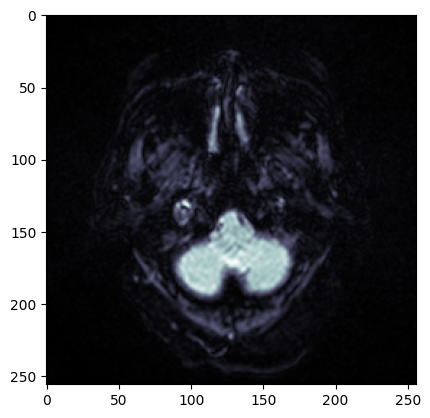

In [69]:
# Example for one DICOM file
ds = pydicom.dcmread(dcm_path)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()

In [70]:


# Replace 'path_to_your_dicom_file' with the actual path to your DICOM file
dicom_file_path = dcm_path
ds = pydicom.dcmread(dicom_file_path)



In [71]:
# Print all metadata
print("DICOM Metadata:\n")
for elem in ds:
    print(f"{elem.tag} {elem.description()}: {elem.value}")

DICOM Metadata:

(0008, 0005) Specific Character Set: ISO_IR 100
(0008, 0008) Image Type: ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM']
(0008, 0012) Instance Creation Date: 20200512
(0008, 0013) Instance Creation Time: 124504.187000
(0008, 0016) SOP Class UID: 1.2.840.10008.5.1.4.1.1.4
(0008, 0018) SOP Instance UID: 1.3.12.2.1107.5.2.30.26961.2020051212444873452388202
(0008, 0020) Study Date: 20200512
(0008, 0021) Series Date: 20200512
(0008, 0022) Acquisition Date: 20200512
(0008, 0023) Content Date: 20200512
(0008, 0030) Study Time: 122821.031000
(0008, 0031) Series Time: 124504.187000
(0008, 0032) Acquisition Time: 124448.055000
(0008, 0033) Content Time: 124504.187000
(0008, 0050) Accession Number: JI200512SMMR033
(0008, 0060) Modality: MR
(0008, 0070) Manufacturer: SIEMENS
(0008, 0080) Institution Name: The Fourth People`s Hospital of Shanghai
(0008, 0081) Institution Address: Si chuan north Road NO.1878,Shang Hai,Hong kou//240C00//,CN,200081
(0008, 0090) Referring Physician's Name: 

In [72]:
dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.DCM')]

# Initialize a list to hold your image data
image_data = []

for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    
    # Preprocess the image as necessary. This is just a placeholder for any actual preprocessing you need to do.
    # For example: image = preprocess(ds.pixel_array)
    image_data.append(ds.pixel_array)
    
    

In [73]:
image_data_np = np.array(image_data)
print(image_data_np.shape)
print(image_data_np.min(), image_data_np.max())


(1000, 256, 256)
0 1654


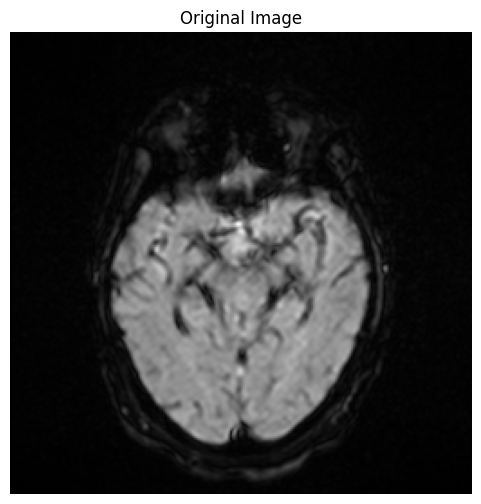

In [74]:
# Assuming 'image_data' is already populated with images from the DICOM files
# Show one of the images before preprocessing
plt.figure(figsize=(6, 6))
plt.imshow(image_data[0], cmap='gray')  # Show the first image in the dataset
plt.title('Original Image')
plt.axis('off')
plt.show()


In [75]:
# Example of applying Gaussian blur for noise reduction
image_data_blurred = [gaussian(image, sigma=1) for image in image_data]

# Example of applying contrast enhancement
image_data_enhanced = [equalize_adapthist(image) for image in image_data_blurred]

# Edge enhancement example is more complex as it usually applies to specific cases.

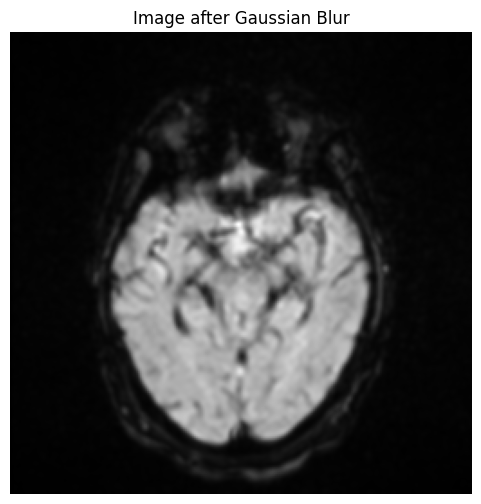

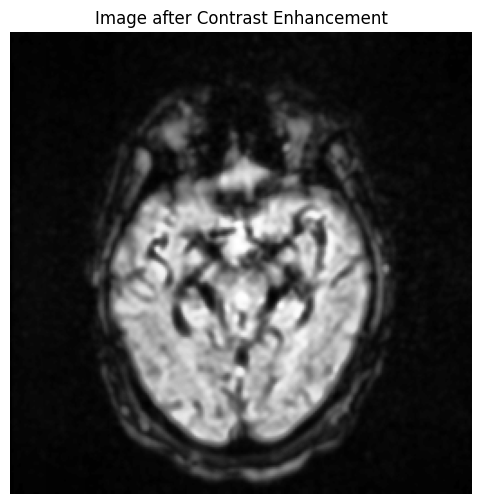

In [76]:
# Apply Gaussian blur to the first image for noise reduction
image_blurred = image_data_blurred[0]

# Apply contrast enhancement to the blurred image
image_enhanced = image_data_enhanced[0]

# Show the blurred image
plt.figure(figsize=(6, 6))
plt.imshow(image_blurred, cmap='gray')
plt.title('Image after Gaussian Blur')
plt.axis('off')
plt.show()

# Show the enhanced image
plt.figure(figsize=(6, 6))
plt.imshow(image_enhanced, cmap='gray')
plt.title('Image after Contrast Enhancement')
plt.axis('off')
plt.show()


In [77]:
# Example of extracting acquisition time from DICOM metadata
acquisition_times = []

for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    
    # Extract acquisition time; note that you'll need to adjust 'AcquisitionTime' based on your DICOM files' metadata structure
    acquisition_time = ds.AcquisitionTime
    acquisition_times.append(acquisition_time)

In [78]:
print(acquisition_times)

['124549.835000', '124450.927500', '124548.477500', '124607.795000', '124547.920000', '124450.687500', '124605.160000', '124604.920000', '124550.952500', '124550.392500', '124505.535000', '124532.592500', '124506.812500', '124506.572500', '124532.035000', '124534.907500', '124534.350000', '124518.305000', '124522.457500', '124516.150000', '124516.390000', '124523.015000', '124518.625000', '124518.865000', '124537.062500', '124500.267500', '124538.340000', '124538.900000', '124500.507500', '124552.150000', '124552.390000', '124502.582500', '124502.822500', '124503.620000', '124503.380000', '124553.187500', '124552.947500', '124538.102500', '124459.707500', '124459.470000', '124537.542500', '124536.265000', '124519.662500', '124519.422500', '124515.592500', '124522.217500', '124521.660000', '124515.352500', '124517.507500', '124535.147500', '124535.707500', '124505.775000', '124531.237500', '124531.795000', '124506.015000', '124504.737500', '124551.192500', '124551.750000', '124605.72000

In [79]:
acquisition_time_seconds = [time_to_seconds(t) for t in acquisition_times]
time_diffs = np.diff(acquisition_time_seconds)
time_diffs = np.append(time_diffs, time_diffs[-1])  # Append the last difference to maintain shape


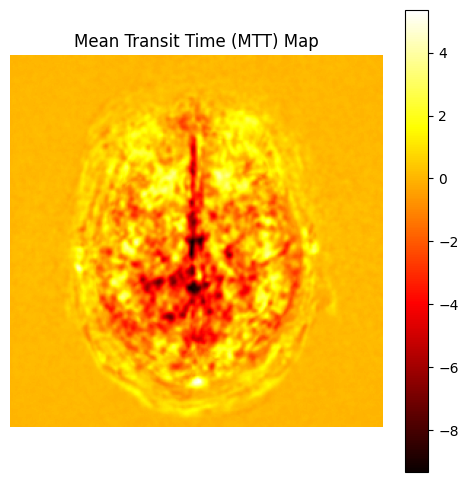

In [80]:
# Step 2: Assuming 'image_data_enhanced' is already aligned with 'acquisition_times'

# Convert 'image_data_enhanced' to a numpy array if it's not already
image_series = np.array(image_data_enhanced)  # This is now your 3D array [time, x, y]

# Step 3: Calculate MTT
# The MTT calculation will depend on your specific methodology.
# The placeholder function 'calculate_mtt' assumes a very simplistic approach and will likely need to be replaced with your actual calculation method.

# Assuming image_series and time_diffs are correctly set up
mtt_map = np.zeros(image_series.shape[1:])  # [x, y]

for x in range(image_series.shape[1]):
    for y in range(image_series.shape[2]):
        pixel_time_series = image_series[:, x, y]
        mtt = calculate_mtt(pixel_time_series, time_diffs)
        mtt_map[x, y] = mtt

# Display the MTT map
plt.figure(figsize=(6, 6))
plt.imshow(mtt_map, cmap='hot')
plt.colorbar()
plt.title('Mean Transit Time (MTT) Map')
plt.axis('off')
plt.show()
